In [74]:
# from lfs_tree import *
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import pydot
import networkx as nx
from string import Template
import pandas as pd
import glob
import pydot
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import seaborn as sns

from IPython.display import Image, display
import matplotlib.pyplot as plt
# from IPython.display import Image, display
import pickle
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
mpl.rcParams.update({
    'font.size': 25,  # Default font size for titles, labels, and tick labels
    'axes.labelsize': 25,  # Font size for axis labels
    'xtick.labelsize': 20,  # Font size for x-axis tick labels
    'ytick.labelsize': 20,  # Font size for y-axis tick labels
    'legend.fontsize': 20  # Font size for the legend
})

In [75]:
# functions

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

def show_trees(directory):
    for f in glob.glob(f'{directory}*tree_*'):
        file = open(f)
        dot_string = file.read()
        print(f)
#             print(dot_string)
        graph = pydot.graph_from_dot_data(dot_string)[0]
        view_pydot(graph)
        print('\n')
            
def show_stats(directory):
    results_files = []
    unsuccessful_cnt = 0
    fs = glob.glob(f'{directory}/**/*experiment_stats')
    df = pd.concat([pd.read_csv(f) for f in fs])
#     print(f"unsuccessful cnt : {unsuccessful_cnt}")
    return df

def determine_shape(x, shape_assignment_dict):
    return shape_assignment_dict[x]

def determine_color(x, color_assignment_dict):
    return color_assignment_dict[x]

def scatter_plots(df, x, y, xlabel, ylabel, title, shape_assignment_dict, color_assignment_dict,
                 first_legend_pos, second_legend_pos, strat_legend_rel_pos, ratio_legend_re_pos):
        
    fig, ax = plt.subplots()
    groups = df.groupby(['strat','complaint_ratio'])
    # Create a scatter plot for each group based on shape and color
    for (strat, ratio), group in groups:
        marker = shape_assignment_dict.get(strat)
        color=color_assignment_dict.get(ratio)
        ax.scatter(group[x], group[y], marker=marker, color=color, label=(strat, ratio))

    # Create separate shape and color legends
    legend_elements_1 = []
    legend_elements_2 = []

    for shape, marker in shape_assignment_dict.items():
        legend_elements_1.append(plt.Line2D([0], [0], marker=marker, color='w', label=shape, markerfacecolor='k'))
    for ratio, color in color_assignment_dict.items():
        legend_elements_2.append(plt.Line2D([0], [0], marker='o', color='w', label=ratio, markerfacecolor=color))

    # Add shape and color legends
    first_legend=ax.legend(handles=legend_elements_1, loc=first_legend_pos, 
                           bbox_to_anchor=strat_legend_rel_pos,
                           title='strategy', 
                           fontsize=13,title_fontsize=14)
    ax.legend(handles=legend_elements_2, loc=second_legend_pos, 
              bbox_to_anchor=ratio_legend_re_pos, title='complaint%',
              fontsize=13, title_fontsize=14)

    ax.add_artist(first_legend)

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)

    plt.show()
    plt.close(fig)
    

def scatter_plot_single_group_value(df, x, y, xlabel, ylabel, title, color_assignment_dict, group_col,
                                   scale, xticks=[], yticks=[]):
    fig, ax = plt.subplots()
    groups = df.groupby([group_col])
    for (g), group in groups:
        color = color_assignment_dict.get(g)
        ax.scatter(group[x], group[y], color=color, label=(g), s=20)  # Set linestyle to an empty string
    if(ylabel=='new_global_accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='black', label='accuracy_before_fix')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_yscale(scale)  # Set the y-axis to logarithmic scale
    if(yticks):
        ax.set_yticks(yticks)
    if(xticks):
        ax.set_xticks(xticks)
    # Customize y-axis ticks and labels
#     ax.set_yticks([0.1, 1, 10, 100])
#     ax.set_yticklabels(['10^-1', '10^0', '10^1', '10^2'])
    ax.legend(fontsize=13,title_fontsize=14)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    
    plt.show()
    plt.close(fig)
    plt.show()
    plt.close(fig)

    
def line_plots(df, x, y, xlabel, ylabel, title, color_assignment_dict, legend_pos,
#                group_name,
#                group_value, 
               gtype='general',
               ylim=None,
              ):
    fig, ax = plt.subplots()
#     df=df[df[group_name]==group_value]
    # Create a scatter plot for each group based on shape and color
    groups = df.groupby(['strat'])
    for strat, group in groups:
        color = color_assignment_dict.get(strat)
        print(f'color: ')
        ax.plot(group[x], group[y], color=color, label=strat)
    if(gtype=='accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='blue', label='accuracy_before_fix')
    ax.legend()
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    if(ylim):
        ax.set_ylim(ylim)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    plt.show()
    plt.close(fig)


def boxplot(df, x, y, xlabel, ylabel, title, yscale=[], xscale=[], yticks=[], xticks=[]):
    plt.figure(figsize=(8, 6))
    
    # Set the y-axis scale
    strat_list = list(df['strat'].unique())
    strat_list.sort()
    
    if(y=='rbbm_runtime' or y=='avg_tree_size_increase'):
        ax=sns.swarmplot(data=df, x=x, y=y, hue='strat', hue_order=strat_list)
    else:
        ax = sns.boxplot(data=df, x=x, y=y, hue='strat', hue_order=strat_list)
        # Change tick label font size for both x and y axes
        
#     ax = sns.boxplot(data=df, x=x, y=y, hue='strat', hue_order=strat_list)
        # Change tick label font size for both x and y axes
    ax.tick_params(axis='both', labelsize=12)
    
    # Add a horizontal line at the specified y-coordinate (line_y)
    if ylabel == 'new_global_accuracy':
#     if line_y is not None:
        ax.axhline(y=float(df['global_accuracy'].mean()), color='red', label='gloabl accuracy before fix',
                  linewidth=5)
        ax.legend(fontsize=14,title_fontsize=15)
        # Create a separate legend for the box plot (customize as needed)
        box_legend = ax.legend(title='Strat',fontsize=13,title_fontsize=15)
    
        # Combine the legends
        ax.add_artist(box_legend)
    else:
        # Create a separate legend for the box plot (customize as needed)
        ax.legend(title='Strat',fontsize=14,title_fontsize=15)
    if yscale:
        ax.set_yscale(yscale)
    
    if xscale:
        ax.set_xscale(xscale)
    
    if yticks:
        ax.set_yticks(yticks)
    
    if xticks:
        ax.set_xticks(xticks)

    plt.title(title,fontsize=20)
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel(ylabel,fontsize=14)

    plt.savefig(f"graph_pdfs/box_{title}.pdf", format="pdf")
    plt.show()



In [76]:
# with open('../experiment_results_folders/retrain_every_x_percent/\
# _20231013002756/20231013002756retrain_bookkeeping_dict.pkl', 'rb') as hf:
#     fix_history_dict = pickle.load(hf)

# with open('../experiment_results_folders/retrain_every_x_percent\
# /_20231013004526/20231013004526_retrain_bookkeeping_dict.pkl', 'rb') as hf2:
#     fix_history_dict_320 = pickle.load(hf2)
        

In [77]:
# data = pd.DataFrame(fix_history_dict)
# data_320 = pd.DataFrame(fix_history_dict_320)

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def retrain_every_x_percent_graph(data, title):
    # Create a figure and define the left and right axes
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(data['number_of_funcs_fixed'], data['fix_rate'], label='fix_rate', color='b', marker='o')
    ax1.plot(data['number_of_funcs_fixed'], data['confirm_preserve_rate'], label='confirm_preserve_rate', color='g', marker='o')
    ax1.plot(data['number_of_funcs_fixed'], data['new_global_accuracy'], label='new_global_accuracy', color='r', marker='o')

    ax2.plot(data['number_of_funcs_fixed'], data['avg_tree_size_increase'], label='avg_tree_size_increase', color='c', marker='o')

    ax1.set_xlabel('number_of_funcs_fixed')
    ax1.set_ylabel('Fix Rate / Confirm Preserve Rate / New Global Accuracy', color='black')
    ax2.set_ylabel('Average Tree Size Increase', color='black')

    plt.title('retrain every 10% of rules')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2

    # Add a legend
    ax1.legend(lines, labels, loc='best')
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    plt.show()
    plt.close(fig)
    # Show the plot
    plt.show()


In [79]:
df_raw = show_stats('../experiment_results_folders/retrain_every_x_percent_reps_1014/')

In [80]:
df_raw.sort_values(by=['user_input_size','retrain_accuracy_thresh','retrain_after_percent'])

,strat,seed,table_name,rbbm_runtime,bbox_runtime,avg_tree_size_increase,user_input_size,complaint_ratio,num_complaints,num_confirmations,global_accuracy,fix_rate,confirm_preserve_rate,new_global_accuracy,prev_signaled_cnt,new_signaled_cnt,num_functions,deletion_factor,post_fix_num_funcs,num_of_funcs_processed_by_algo,complaint_reached_max,confirm_reached_max,lf_source,retrain_after_percent,retrain_accuracy_thresh,load_funcs_from_pickle,pre_deletion_threshold
0,information_gain,123,youtube,0.707,25.737,2.466667,100,0.5,50,50,0.821,0.520,0.980,0.864,1412,1412,30,0.0,30,30,False,False,undefined,0.1,0.6,True,0.0
0,information_gain,123,youtube,0.992,16.928,2.466667,100,0.5,50,50,0.821,0.520,0.980,0.864,1412,1412,30,0.0,30,30,False,False,undefined,0.2,0.6,True,0.0
0,information_gain,123,youtube,0.685,11.599,2.466667,100,0.5,50,50,0.821,0.520,0.980,0.864,1412,1412,30,0.0,30,30,False,False,undefined,0.3,0.6,True,0.0
0,information_gain,123,youtube,0.835,11.369,2.466667,100,0.5,50,50,0.821,0.520,0.980,0.864,1412,1412,30,0.0,30,30,False,False,undefined,0.4,0.6,True,0.0
0,information_gain,123,youtube,0.838,6.834,2.466667,100,0.5,50,50,0.821,0.520,0.980,0.864,1412,1412,30,0.0,30,30,False,False,undefined,0.5,0.6,True,0.0
0,information_gain,123,youtube,0.692,26.047,2.466667,100,0.5,50,50,0.821,0.520,0.980,0.864,1412,1412,30,0.0,30,30,False,False,undefined,0.1,0.7,True,0.0
0,information_gain,123,youtube,0.832,13.263,2.466667,100,0.5,50,50,0.821,0.520,0.980,0.864,1412,1412,30,0.0,30,30,False,False,undefined,0.2,0.7,True,0.0
0,information_gain,123,youtube,0.692,11.522,2.466667,100,0.5,50,50,0.821,0.520,0.980,0.864,1412,1412,30,0.0,30,30,False,False,undefined,0.3,0.7,True,0.0
0,information_gain,123,youtube,0.667,9.418,2.466667,100,0.5,50,50,0.821,0.520,0.980,0.864,1412,1412,30,0.0,30,30,False,False,undefined,0.4,0.7,True,0.0
0,information_gain,123,youtube,1.004,7.338,2.466667,100,0.5,50,50,0.821,0.520,0.980,0.864,1412,1412,30,0.0,30,30,False,False,undefined,0.5,0.7,True,0.0


In [81]:
df = show_stats('../experiment_results_folders/retrain_every_x_percent_reps_1014/')

In [82]:
df = df.sort_values('retrain_after_percent')[['rbbm_runtime','bbox_runtime','user_input_size',\
                                         'retrain_after_percent','num_of_funcs_processed_by_algo',\
                                         'avg_tree_size_increase','retrain_accuracy_thresh',\
                                              'new_global_accuracy','global_accuracy']].sort_values(by=[\
                                        'user_input_size','retrain_accuracy_thresh','retrain_after_percent'])

In [83]:
df.shape

(126, 9)

In [84]:
df_summary = df.groupby(['user_input_size','retrain_accuracy_thresh','retrain_after_percent']).mean().reset_index()

In [85]:
df_summary['runtime']=df_summary['rbbm_runtime']+ df_summary['bbox_runtime']

In [86]:
df_summary.sort_values(by=['user_input_size','retrain_accuracy_thresh',\
                           'retrain_after_percent'])[['user_input_size',\
                                                      'retrain_accuracy_thresh',\
                                                      'retrain_after_percent',\
                                                     'global_accuracy','new_global_accuracy']]

,user_input_size,retrain_accuracy_thresh,retrain_after_percent,global_accuracy,new_global_accuracy
0,100,0.6,0.1,0.821,0.864
1,100,0.6,0.2,0.821,0.864
2,100,0.6,0.3,0.821,0.864
3,100,0.6,0.4,0.821,0.864
4,100,0.6,0.5,0.821,0.864
5,100,0.7,0.1,0.821,0.864
6,100,0.7,0.2,0.821,0.864
7,100,0.7,0.3,0.821,0.864
8,100,0.7,0.4,0.821,0.864
9,100,0.7,0.5,0.821,0.864


In [87]:
import matplotlib.pyplot as plt
import numpy as np

# # Your data
# d = {'runtime': [1, 2, 3, 4], 'increase': [100, 200, 300, 400], 'type': [1, 2, 1, 2]}

# # Convert data to a DataFrame
# import pandas as pd
# df = pd.DataFrame(d)

# Group data by 'type'
def plot_retrain_time_and_size(user_input_size, acc_thresh, df):
    
    df = df[(df['user_input_size']==user_input_size) & (df['retrain_accuracy_thresh']==acc_thresh)]
    grouped_data = df.groupby(['retrain_after_percent'])

    # Extract 'runtime' and 'increase' values for each group
    runtime_values = grouped_data['runtime'].mean()
    increase_values = grouped_data['avg_tree_size_increase'].mean()

    # Type labels and positions for the x-axis
    types = sorted(df['retrain_after_percent'].unique())  # Unique types
    x_pos = np.arange(len(types))  # X-axis positions for the bars

    # Create a figure and axis for the plot
#     fig, ax1 = plt.subplots()
    fig, ax1 = plt.subplots(figsize=(6.5, 4))  # Adjust the width (8) and height (4) as needed


    # Plot bars for 'runtime' on the primary y-axis (left)
    ax1.bar(x_pos - 0.2, runtime_values, width=0.4, label='runtime', color='#3bb5b9')
    ax1.set_ylabel('runtime(sec)')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(types)
    ax1.set_xlabel('retrain frequency')

    # Create a secondary y-axis (right)
    ax2 = ax1.twinx()

    # Plot bars for 'increase' on the secondary y-axis (right)
    ax2.bar(x_pos + 0.2, increase_values, width=0.4, color='#f7545b', label='avg size incr.')
    ax2.set_ylabel('avg size incr.')

    # Add legends for both bars
#     ax1.legend(loc='upper left',bbox_to_anchor=(-0.15, 1.2))
#     ax2.legend(loc='upper right',bbox_to_anchor=(1.15, 1.2))

    # Set plot title and show the plot
    plt.title(f'input size={user_input_size}')
    plt.savefig(f'graph_pdfs/retrain_every_x_{user_input_size}_runtime.pdf', format='pdf',bbox_inches='tight', pad_inches=0.2)

    plt.show()

    # Group data by 'type'
def plot_retrain_accuracy(user_input_size, acc_thresh, df):
    
    df = df[(df['user_input_size']==user_input_size) & (df['retrain_accuracy_thresh']==acc_thresh)]
    grouped_data = df.groupby(['retrain_after_percent'])

    # Extract 'runtime' and 'increase' values for each group
    old_global = grouped_data['global_accuracy'].mean()
    increase_values = grouped_data['new_global_accuracy'].mean()
    print(increase_values)
    # Type labels and positions for the x-axis
    types = sorted(df['retrain_after_percent'].unique())  # Unique types
    x_pos = np.arange(len(types))  # X-axis positions for the bars

    # Create a figure and axis for the plot
#     fig, ax1 = plt.subplots()
    fig, ax1 = plt.subplots(figsize=(6.5, 4))  # Adjust the width (8) and height (4) as needed


    # Plot bars for 'runtime' on the primary y-axis (left)
    ax1.bar(x_pos - 0.2, old_global, color='#58ce6c', width=0.4, label='global accuracy')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(types)
    ax1.set_xlabel('retrain frequency')

#     # Create a secondary y-axis (right)
#     ax2 = ax1.twinx()

    # Plot bars for 'increase' on the secondary y-axis (right)
    ax1.bar(x_pos + 0.2, increase_values, width=0.4, color='#f6802a', label='new global accuracy')
    ax1.set_ylabel('global acc.')

    # Add legends for both bars
#     ax1.legend(loc='lower left')
    ax1.set_ylim([0.5,1])

    # Set plot title and show the plot
    plt.title(f'input size={user_input_size}')
    plt.savefig(f'graph_pdfs/retrain_every_x_{user_input_size}_accuracy.pdf', format='pdf',bbox_inches='tight', pad_inches=0.2)

    plt.show()

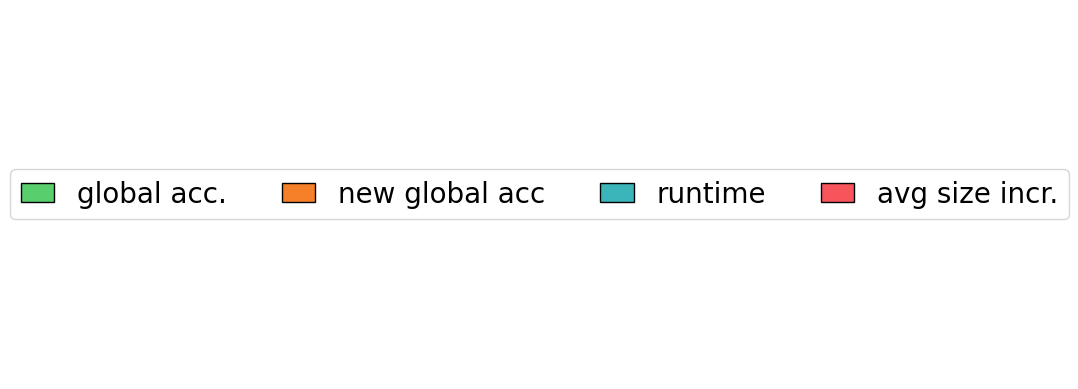

In [101]:
def line_plots_legends_only(color_assignment_dict):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Remove background grid
    ax.set_axis_off()

    # Create custom legend entries
    legend_entries = []

    for strat, color in color_assignment_dict.items():
            legend_entries.append(mpatches.Patch(facecolor=color, edgecolor='black', label=strat))
#             legend_entries.append(mlines.Line2D([], [], color=color, label=strat, markersize=30))
    # Use Seaborn to add a legend
#     ax.legend(handles=legend_entries, loc='center', title='Strat')
    ax.legend(handles=legend_entries, loc='center', ncol=4,     handlelength=1.2)
    plt.savefig(f"graph_pdfs/retrain_x_legend_only.pdf", format="pdf",bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
custom_palette = ['#58ce6c', '#f6802a', '#3bb5b9', '#f7545b']
strats = ['global acc.', 'new global acc', 'runtime', 'avg size incr.']

color_dict = dict(zip(strats, custom_palette))

line_plots_legends_only(color_dict)

retrain_after_percent
0.1    0.864
0.2    0.864
0.3    0.864
0.4    0.864
0.5    0.864
Name: new_global_accuracy, dtype: float64


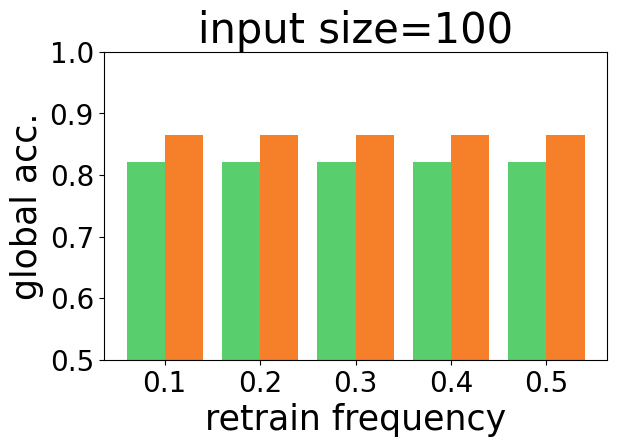

retrain_after_percent
0.1    0.921
0.2    0.921
0.3    0.924
0.4    0.921
0.5    0.922
Name: new_global_accuracy, dtype: float64


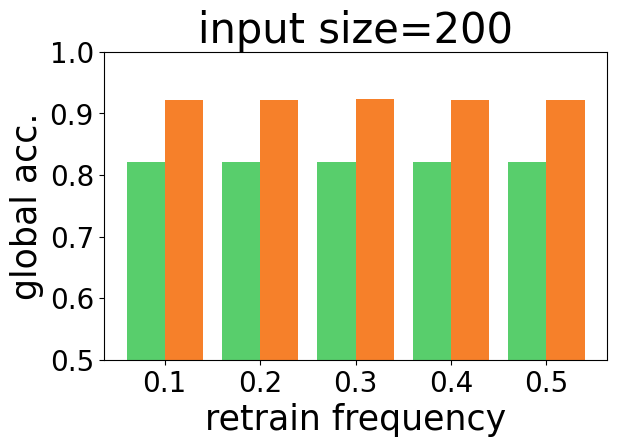

retrain_after_percent
0.1    0.889
0.2    0.917
0.3    0.927
0.4    0.917
0.5    0.935
Name: new_global_accuracy, dtype: float64


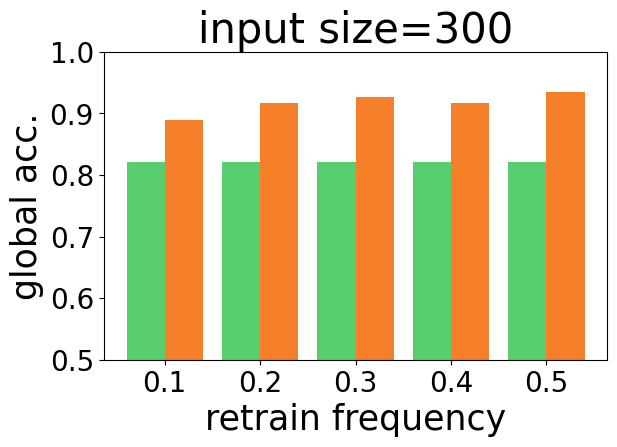

retrain_after_percent
0.1    0.912
0.2    0.935
0.3    0.939
0.4    0.935
0.5    0.953
Name: new_global_accuracy, dtype: float64


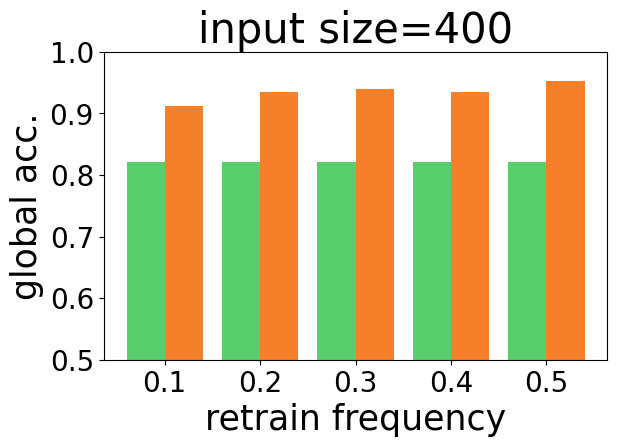

In [89]:
for acc in [0.6]:
    for size in [100, 200, 300, 400]:
        plot_retrain_accuracy(size, acc, df_summary)

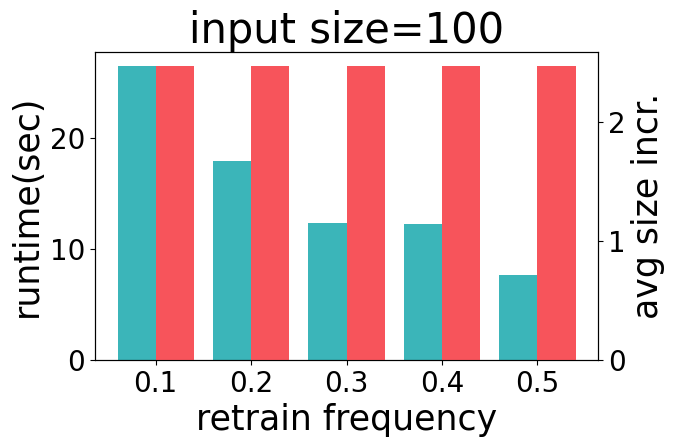

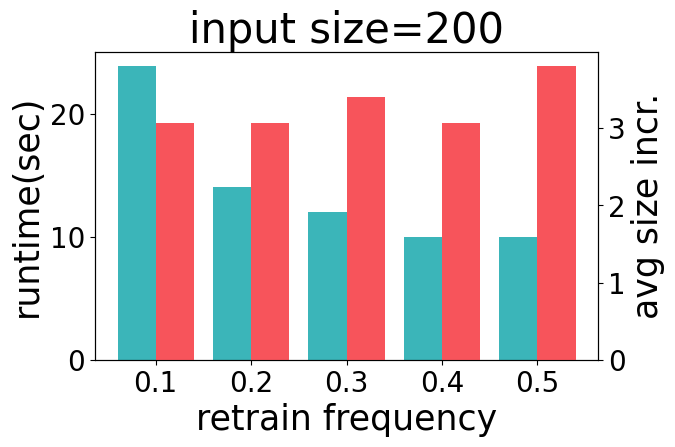

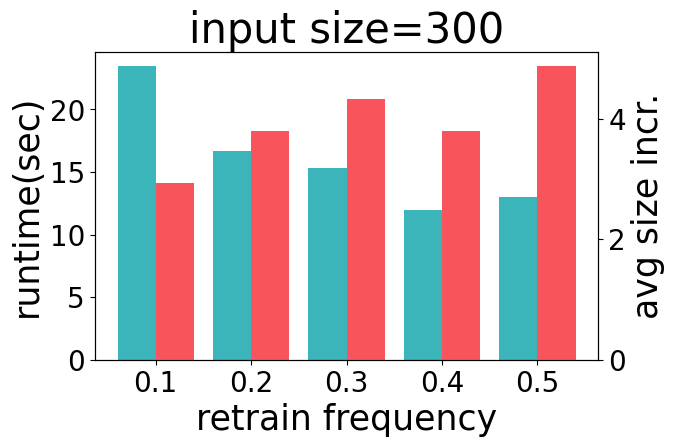

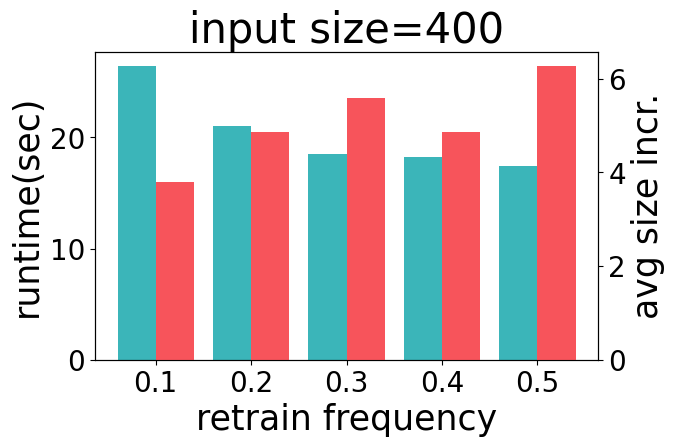

In [90]:
for acc in [0.6]:
    for size in [100, 200, 300, 400]:
        plot_retrain_time_and_size(size, acc, df_summary)